Some good references:
1. https://towardsdatascience.com/a-bunch-of-tips-and-tricks-for-training-deep-neural-networks-3ca24c31ddc8
2. https://towardsdatascience.com/review-densenet-image-classification-b6631a8ef803

In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet169
import keras
import cv2
import os
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,balanced_accuracy_score
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
print(os.listdir("../input"))

['aptos2019-blindness-detection', 'densenet-keras']


Using TensorFlow backend.


In [3]:

class QWKCallback(Callback):
    def __init__(self,validation_data):
        super(Callback, self).__init__()
        self.X = validation_data[0]
        self.Y = validation_data[1]
        self.history = []
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.X)
        score = cohen_kappa_score(np.argmax(self.Y,axis=1),np.argmax(pred,axis=1),labels=[0,1,2,3,4],weights='quadratic')
        print("Epoch {} : QWK: {}".format(epoch,score))
        self.history.append(score)
        if score >= max(self.history):
            print('saving checkpoint: ', score)
            self.model.save('../working/DenseNet169_bestqwk.h5')
        
        
    

In [4]:

class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [5]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [6]:
def load_raw_images_df(data_frame,filenamecol,labelcol,img_size,n_classes):
    n_images = len(data_frame)
    X = np.empty((n_images,img_size,img_size,3))
    Y = np.zeros((n_images,n_classes))
    for index,entry in data_frame.iterrows():
        Y[index,entry[labelcol]] = 1 # one hot encoding of the label
        # Load the image and resize
        img = cv2.imread(entry[filenamecol])
        X[index,:] = cv2.resize(img, (img_size, img_size))
        X[index,:] = X[index,:] / 255.0
    return X,Y

In [7]:
batch_size = 32
img_size = 224

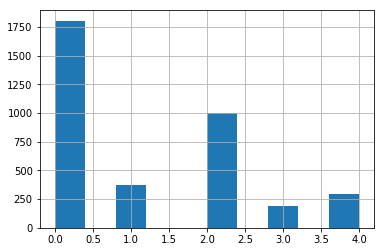

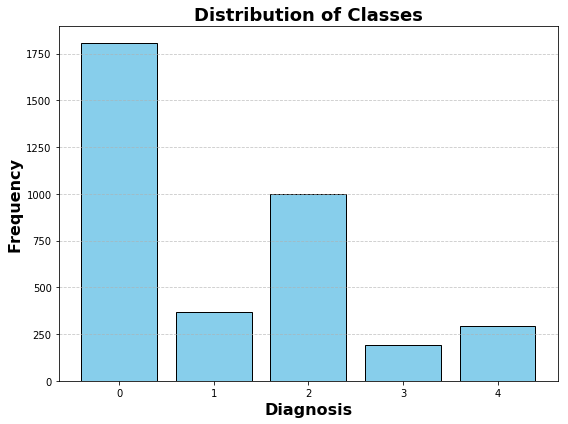

In [8]:

train_raw_data = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")

# Create a new column 'filename' by mapping the image paths
train_raw_data["filename"] = train_raw_data["id_code"].map(lambda x: os.path.join("../input/aptos2019-blindness-detection/train_images", x + ".png"))

# Display the distribution of classes using a histogram
train_raw_data.diagnosis.hist()
plt.figure(figsize=(8, 6))
plt.hist(train_raw_data.diagnosis, bins=range(6), align='left', rwidth=0.8, color='skyblue', edgecolor='black')
plt.xlabel('Diagnosis', fontsize=16, fontweight='bold')  # Increase font size and set bold font
plt.ylabel('Frequency', fontsize=16, fontweight='bold')  # Increase font size and set bold font
plt.title('Distribution of Classes', fontsize=18, fontweight='bold')  # Increase font size and set bold font
plt.xticks(ticks=range(5), labels=range(5))  # Set the x-axis ticks to match the number of classes (assuming 5 classes)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
train_raw_data["diagnosis"].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [10]:
label_title = {"0" : "No DR","1" : "Mild","2" : "Moderate","3" :"Severe","4" : "Proliferative DR"}
class_labels=["No DR","Mild","Moderate","Severe","Proliferative DR"]

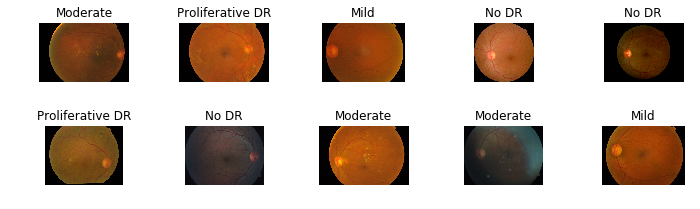

In [11]:
# Create subplots with a 5x2 grid
fig, ax = plt.subplots(2, 5, figsize=(10, 3))
ax = ax.flatten()

for i, (index, row) in enumerate(train_raw_data.iloc[0:10,:].iterrows()):
    img = cv2.imread(os.path.join("../input/aptos2019-blindness-detection/train_images", row["id_code"] + ".png"))
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_title(label_title[str(row["diagnosis"])])
    ax[i].axis('off')  # Hide axes
    
plt.tight_layout()
plt.show()

In [12]:
train_df,val_df = train_test_split(train_raw_data,random_state=42,shuffle=True,test_size=0.30)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)

In [13]:
X_train,Y_train = load_raw_images_df(train_df,"filename","diagnosis",img_size,5)
X_val,Y_val = load_raw_images_df(val_df,"filename","diagnosis",img_size,5)


In [14]:
Y_train_labels = np.argmax(Y_train,axis=1)
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train_labels),Y_train_labels)
cls_wt_dict = dict(enumerate(class_weights))
print(cls_wt_dict)

{0: 0.4052173913043478, 1: 1.8845588235294117, 2: 0.7354375896700144, 3: 3.714492753623188, 4: 2.6837696335078536}


In [15]:
datagen = ImageDataGenerator(
            
            zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)
training_generator = MixupGenerator(X_train, Y_train, batch_size=batch_size, alpha=0.2, datagen=datagen)()

In [16]:
def buildModel():
    DenseNet169_model = DenseNet169(include_top=False,weights='imagenet',input_tensor=keras.layers.Input(shape=(img_size,img_size,3)))
  

    
    p  = keras.layers.GlobalAveragePooling2D()(DenseNet169_model.output)

    d11 = keras.layers.Dense(units = 256, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.0001))(p)
    o1 = keras.layers.Dense(units = 5, activation = 'softmax')(d11)
    model = keras.models.Model(inputs = DenseNet169_model.input,outputs = o1)
    adam = keras.optimizers.adam()
    model.compile(optimizer=adam,loss='categorical_crossentropy', metrics = ['accuracy'])
    print(model.summary())
    return model

In [17]:
mymodel = buildModel()

51879936/51877672 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________

In [18]:
EPOCHS = 16
earlystop = keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpoint = keras.callbacks.ModelCheckpoint('../working/DenseNet169.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
qwk = QWKCallback((X_val,Y_val))
mycallbacks = [earlystop, learning_rate_reduction,checkpoint,qwk]

In [19]:
print(qwk)

In [20]:
# Warm up the model with class weights
EPOCHS = 10
history = mymodel.fit_generator(training_generator,steps_per_epoch = X_train.shape[0] // batch_size,epochs = EPOCHS,
                         validation_data = (X_val,Y_val),
                         validation_steps = 10,
                         workers = 2,use_multiprocessing=True,
                         verbose=2, callbacks=mycallbacks,
                         class_weight=cls_wt_dict)


Epoch 1/10


/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


 - 80s - loss: 1.3315 - acc: 0.5824 - val_loss: 3.3940 - val_acc: 0.4340

Epoch 00001: val_loss improved from inf to 3.39397, saving model to ../working/DenseNet169.h5
Epoch 0 : QWK: 0.4867849570802867
saving checkpoint:  0.4867849570802867
Epoch 2/10
 - 33s - loss: 1.3107 - acc: 0.5902 - val_loss: 1.1510 - val_acc: 0.5150

Epoch 00002: val_loss improved from 3.39397 to 1.15101, saving model to ../working/DenseNet169.h5
Epoch 1 : QWK: 0.6981875581362573
saving checkpoint:  0.6981875581362573
Epoch 3/10
 - 32s - loss: 1.2278 - acc: 0.6398 - val_loss: 0.8983 - val_acc: 0.6697

Epoch 00003: val_loss improved from 1.15101 to 0.89832, saving model to ../working/DenseNet169.h5
Epoch 2 : QWK: 0.6071259485905925
Epoch 4/10
 - 33s - loss: 1.1574 - acc: 0.6453 - val_loss: 1.5757 - val_acc: 0.5278

Epoch 00004: val_loss did not improve from 0.89832
Epoch 3 : QWK: 0.7482878026574034
saving checkpoint:  0.7482878026574034
Epoch 5/10
 - 33s - loss: 1.1619 - acc: 0.6832 - val_loss: 1.0985 - val_acc: 

In [21]:
EPOCHS = 50
history = mymodel.fit_generator(training_generator,steps_per_epoch = X_train.shape[0] // batch_size,epochs = EPOCHS,
                         validation_data = (X_val,Y_val),
                         validation_steps = 10,
                         workers = 2,use_multiprocessing=True,
                         verbose=2, callbacks=mycallbacks)

Epoch 1/50
 - 36s - loss: 0.7139 - acc: 0.7836 - val_loss: 0.6408 - val_acc: 0.7616

Epoch 00001: val_loss improved from 0.65313 to 0.64083, saving model to ../working/DenseNet169.h5
Epoch 0 : QWK: 0.855636383870326
saving checkpoint:  0.855636383870326
Epoch 2/50
 - 33s - loss: 0.6702 - acc: 0.7895 - val_loss: 0.5621 - val_acc: 0.8144

Epoch 00002: val_loss improved from 0.64083 to 0.56213, saving model to ../working/DenseNet169.h5
Epoch 1 : QWK: 0.8534989734577334
Epoch 3/50
 - 32s - loss: 0.6461 - acc: 0.8039 - val_loss: 0.6728 - val_acc: 0.7971

Epoch 00003: val_loss did not improve from 0.56213
Epoch 2 : QWK: 0.8384846386808762
Epoch 4/50
 - 32s - loss: 0.6208 - acc: 0.8113 - val_loss: 0.5527 - val_acc: 0.8135

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00004: val_loss improved from 0.56213 to 0.55272, saving model to ../working/DenseNet169.h5
Epoch 3 : QWK: 0.8674414778508099
saving checkpoint:  0.8674414778508099
Epoch 5/50
 - 32s - lo

In [22]:
mymodel.save_weights("model.h5")

In [23]:
Y_val_pred = mymodel.predict_on_batch(X_val)

In [24]:
Y_val_pred_hot = np.argmax(Y_val_pred,axis=1)
Y_val_actual_hot = np.argmax(Y_val,axis=1)

Confusion matrix, without normalization
[[533   7   0   0   0]
 [ 11  54  32   0   1]
 [  9  28 252   9   4]
 [  1   0  24  23   7]
 [  0   5  41  13  45]]


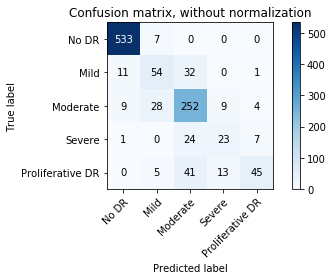

In [25]:
plot_confusion_matrix(Y_val_actual_hot, Y_val_pred_hot, np.array(class_labels))

In [26]:
report = classification_report(Y_val_actual_hot, Y_val_pred_hot)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       540
           1       0.57      0.55      0.56        98
           2       0.72      0.83      0.77       302
           3       0.51      0.42      0.46        55
           4       0.79      0.43      0.56       104

    accuracy                           0.83      1099
   macro avg       0.71      0.64      0.67      1099
weighted avg       0.82      0.83      0.82      1099



In [27]:
history.history['val_loss']

[0.640826949241272,
 0.5621332823416664,
 0.6728224953377214,
 0.5527152031849903,
 0.5630799165848063,
 0.585488241135369,
 0.553900936552348,
 0.5325546443625078,
 0.5093377795243285,
 0.52255525249476,
 0.5213651266610004,
 0.5106296192200429,
 0.5192862178001543,
 0.5182479329820759,
 0.5185485995824604,
 0.5058427817502599,
 0.516171789093382,
 0.5125147721461538,
 0.519802417236637,
 0.5109880287827309,
 0.5082086463534257,
 0.5219145047870737,
 0.5169365180959693,
 0.5067847882540688,
 0.5058256915962837,
 0.5051660071838108,
 0.5079530880492421,
 0.5116431533585254,
 0.509879333795039,
 0.5244321970640257,
 0.5175481517820384,
 0.5115579206147337,
 0.53006308836976,
 0.5142976491423061,
 0.5112675177280853,
 0.5239530734521243]

In [28]:
history.history['val_acc']

[0.7616014560859131,
 0.814376706042216,
 0.7970882622733563,
 0.8134667882060224,
 0.7952684260586156,
 0.7907188352505872,
 0.8034576890249486,
 0.8116469519912817,
 0.8262056417092071,
 0.8116469519912817,
 0.8216560511723554,
 0.8225659692797257,
 0.8134667882060224,
 0.8198362149576147,
 0.8189262968502444,
 0.8271155598165774,
 0.8234758873870961,
 0.8216560511723554,
 0.8198362149576147,
 0.8225659692797257,
 0.8262056417092071,
 0.8189262968502444,
 0.8216560511723554,
 0.8307552322460587,
 0.8298453141386885,
 0.8243858054944664,
 0.828935396031318,
 0.820746133064985,
 0.8280254779239478,
 0.8271155598165774,
 0.8298453141386885,
 0.8271155598165774,
 0.8171064606355037,
 0.8234758873870961,
 0.8298453141386885,
 0.8252957236018368]

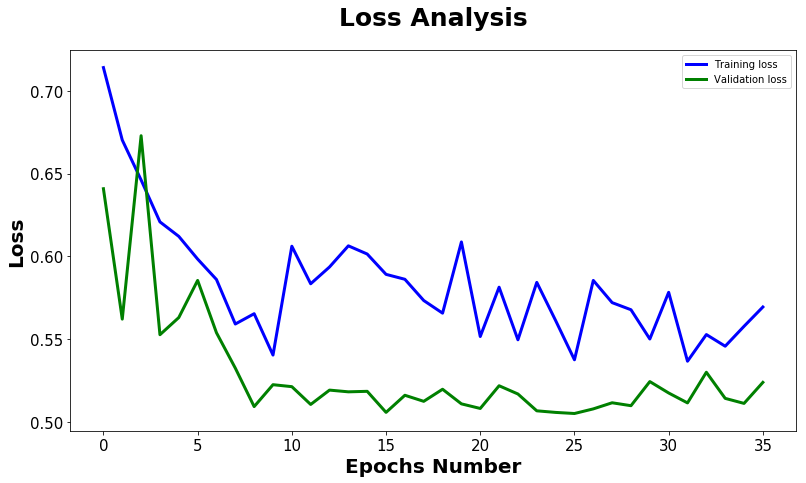

In [29]:
plt.figure(figsize=(13, 7))
plt.title("Loss Analysis", fontsize=25, weight='bold', y=1.05)
number_of_epochs = range(len(history.history['loss']))
plt.plot(number_of_epochs, history.history['loss'], color='b', label="Training loss", linewidth=3)
plt.plot(number_of_epochs, history.history['val_loss'], color='g', label="Validation loss", linewidth=3)



plt.xlabel("Epochs Number", size=20, weight='bold', y=1.05)
plt.ylabel("Loss", size=20, weight='bold', x=1.05)
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend()
plt.show()


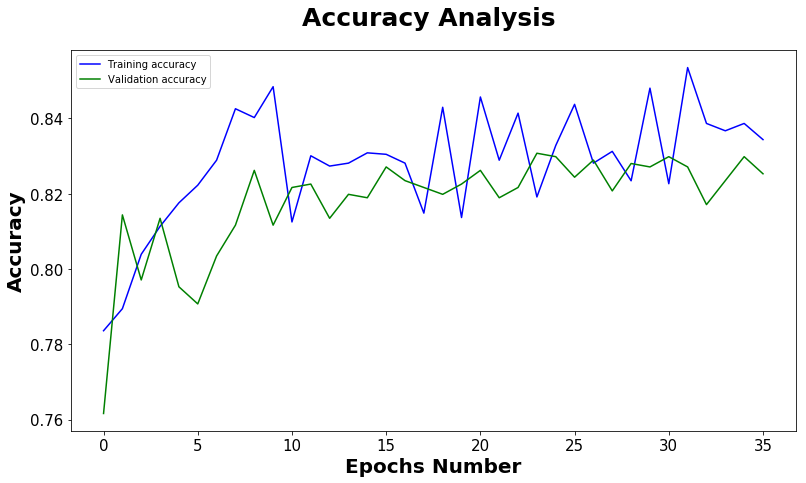

In [30]:
plt.figure(figsize=(13, 7))
plt.title("Accuracy Analysis ",fontsize=25,weight='bold',y=1.05)
plt.plot(history.history['acc'], color='b', label="Training accuracy")
plt.plot(history.history['val_acc'], color='g',label="Validation accuracy")

    
plt.xlabel("Epochs Number",size=20,weight='bold',y=1.05)
plt.ylabel("Accuracy",size=20,weight='bold',x=1.05)
plt.xticks(size =15)
plt.yticks(size =15)
plt.legend()
plt.savefig("Accuracy   of achitechture")
plt.show()

In [31]:
weighted_accuracy = balanced_accuracy_score(Y_val_actual_hot, Y_val_pred_hot)
print("Weighted Accuracy:", weighted_accuracy)

Weighted Accuracy: 0.6446737314334285


In [32]:
test_data = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
test_data["filename"] = test_data["id_code"].map(lambda x:x+".png")
test_data.head()

,id_code,filename
0,0005cfc8afb6,0005cfc8afb6.png
1,003f0afdcd15,003f0afdcd15.png
2,006efc72b638,006efc72b638.png
3,00836aaacf06,00836aaacf06.png
4,009245722fa4,009245722fa4.png


In [33]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(  
        dataframe=test_data,
        directory = "../input/aptos2019-blindness-detection/test_images",    
        x_col="filename",
        y_col=None,
        target_size = (img_size,img_size),
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )

Found 1928 validated image filenames.


In [34]:
predictions = mymodel.predict_generator(test_generator, steps = len(test_generator.filenames))

In [35]:
filenames=test_generator.filenames
results=pd.DataFrame({"id_code":filenames,
                      "diagnosis":np.argmax(predictions,axis=1)})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv("submission.csv",index=False)

<a href="submission.csv">submission.csv</a>

array([0, 4, 2, 3])

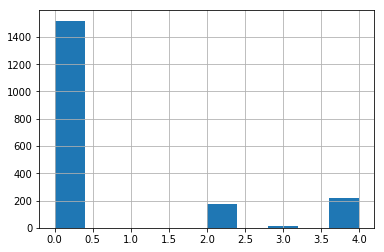

In [36]:
results.diagnosis.hist()
results.diagnosis.unique()

In [37]:
mymodel.save('my_model.h5')